In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_pacf
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
import matplotlib.pyplot as plt
from pprint import pp
from statsmodels.tsa.statespace.varmax import VARMAX
from datetime import datetime

In [2]:
# Import and clean data
newspaper_df = pd.read_csv("news_sent_over_time.csv", keep_default_na=False)
newspaper_df.rename({"published_date": "date"}, inplace=True, axis=1)
print(f'{newspaper_df["date"].max() = }')

# make it into one column
newspaper_df['articles'] = newspaper_df["NEGATIVE"]+newspaper_df["POSITIVE"]
newspapers = newspaper_df.drop(['NEGATIVE', 'POSITIVE'], axis=1)
print(newspapers.shape)
print(newspapers.head())


debates_df = pd.read_csv("speeches_per_date.csv", keep_default_na=False)
debates_df['speeches'] = debates_df["NEGATIVE"]+debates_df["POSITIVE"]
debates = debates_df.drop(['NEGATIVE', 'POSITIVE'], axis=1)
print(debates.shape)
print(debates.head())

newspaper_df["date"].max() = '2023-02-20'
(463, 2)
         date  articles
0  2021-11-01         6
1  2021-11-02         6
2  2021-11-03         3
3  2021-11-04         6
4  2021-11-05         6
(488, 2)
         date  speeches
0  2021-11-01         2
1  2021-11-02         1
2  2021-11-03         6
3  2021-11-04         1
4  2021-11-05         0


In [3]:
merged_df = newspapers.merge(
    debates, on="date", how="left")

merged_df.set_index("date", inplace=True)

print(merged_df.head())

            articles  speeches
date                          
2021-11-01         6         2
2021-11-02         6         1
2021-11-03         3         6
2021-11-04         6         1
2021-11-05         6         0


In [4]:
# Stationarity function
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [5]:
# Differencing
adf_test(merged_df["articles"])

merged_df_diff = merged_df.diff()
#merged_df_diff = merged_df_diff.iloc[1:]
merged_df_diff = merged_df_diff.fillna(0)
adf_test(merged_df_diff["articles"])
print(merged_df_diff.head(2))

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.163495
p-value                   0.219760
# lags used              18.000000
# observations          444.000000
critical value (1%)      -3.445164
critical value (5%)      -2.868072
critical value (10%)     -2.570249
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
Augmented Dickey-Fuller Test: 
ADF test statistic     -7.260523e+00
p-value                 1.686254e-10
# lags used             1.800000e+01
# observations          4.440000e+02
critical value (1%)    -3.445164e+00
critical value (5%)    -2.868072e+00
critical value (10%)   -2.570249e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
            articles  speeches
date                          
2021-11-01       0.0       0.0
2021-11-02       0.0      -1.0


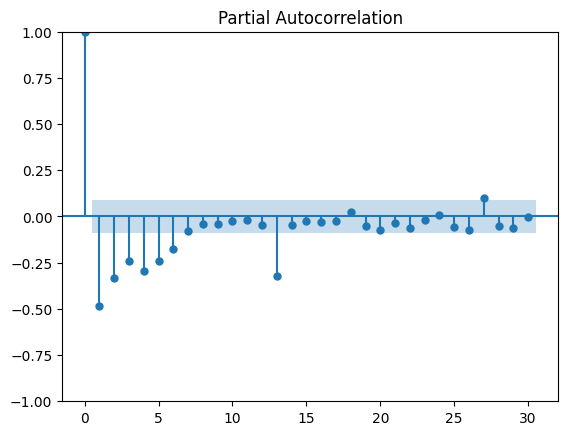

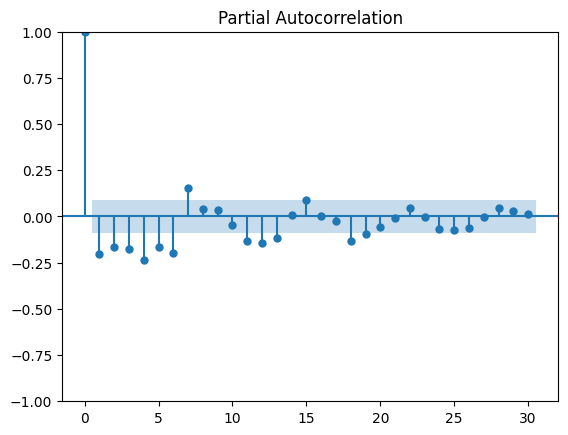

In [6]:
# Determine lags
plot_pacf(merged_df_diff["speeches"], method = "ols", lags = 30)
plt.show()
## lag 6 

plot_pacf(merged_df_diff["articles"], method = "ols", lags = 30)
plt.show()
## lag 6 

In [7]:
corr = merged_df['articles'].corr(merged_df['speeches'], method='pearson')
pp(corr)

0.2082137797005695


In [8]:
model = VAR(merged_df_diff)
model_fit = model.fit(maxlags=6, ic="aic")
model_fit.summary()

/home/debian/miniconda3/envs/debates/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 09, May, 2023
Time:                     08:28:15
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    10.3019
Nobs:                     457.000    HQIC:                   10.1597
Log likelihood:          -3571.28    FPE:                    23559.6
AIC:                      10.0673    Det(Omega_mle):         22274.3
--------------------------------------------------------------------
Results for equation articles
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.080767         0.376797            0.214           0.830
L1.articles        -0.410657         0.046992           -8.739           0.000
L1.speeches         0.084153         0.020427            4.120   

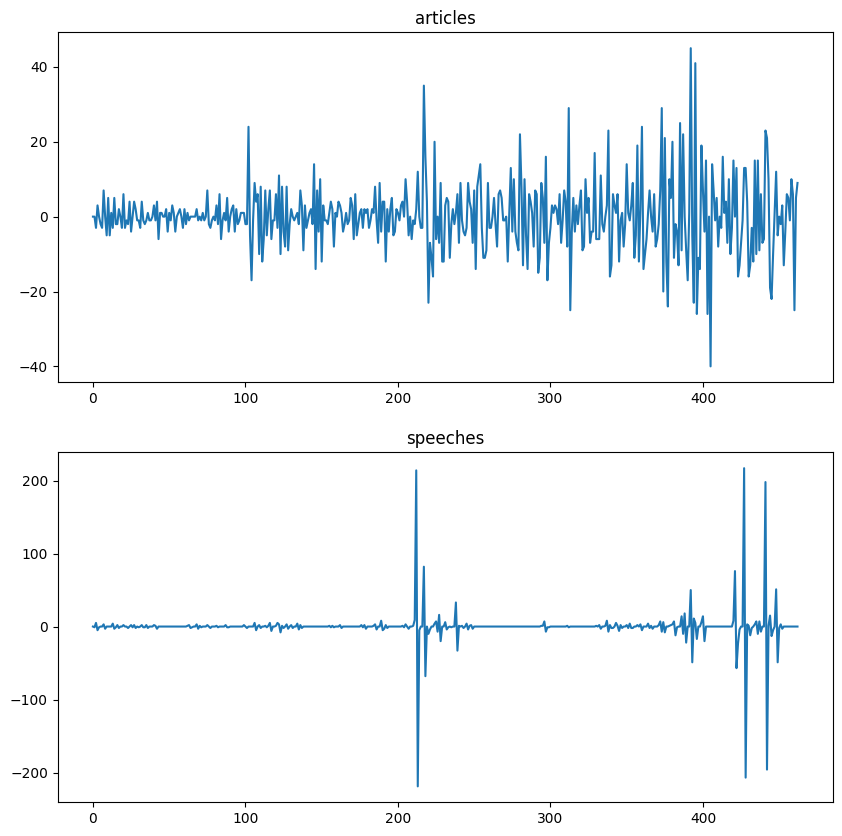

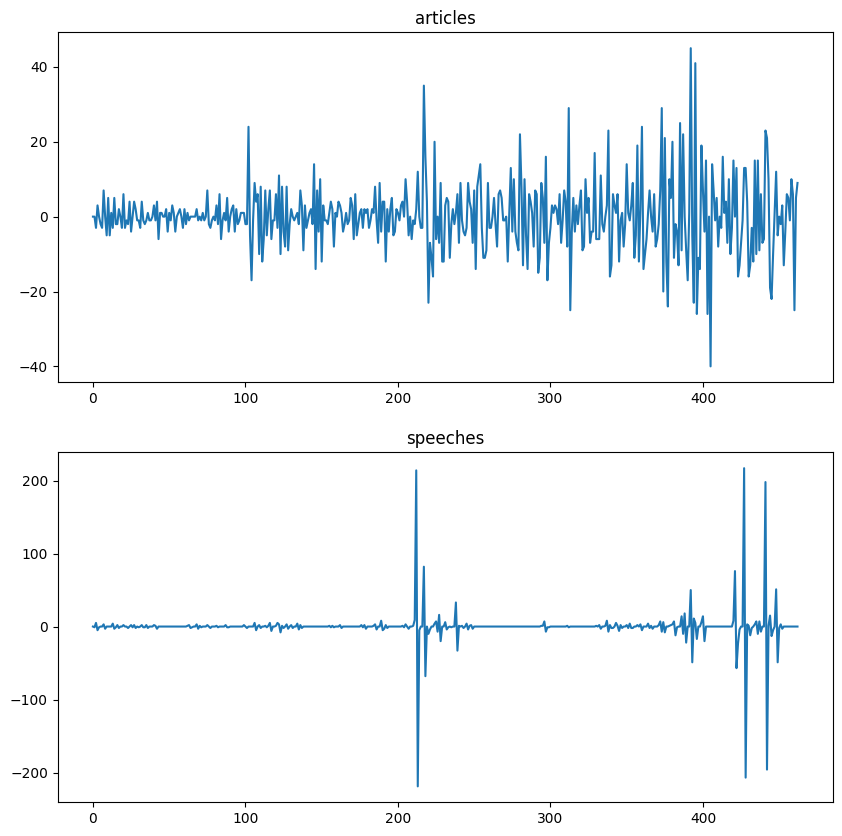

In [9]:
model_fit.plot()

In [18]:
sorted_order=model.select_order(maxlags=6)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       10.93       10.95   5.604e+04       10.94
1       10.60       10.66   4.033e+04       10.63
2       10.40       10.50   3.302e+04       10.44
3       10.29       10.42   2.941e+04       10.34
4       10.17       10.33   2.602e+04       10.23
5       10.12       10.32   2.480e+04       10.20
6      10.07*      10.30*  2.356e+04*      10.16*
-------------------------------------------------


In [21]:
model_fit.test_normality()
print(str(model_fit.test_normality()))

print(str(model_fit.test_whiteness(nlags=7)))

<statsmodels.tsa.vector_ar.hypothesis_test_results.NormalityTestResults object. H_0: data generated by normally-distributed process: reject at 5% significance level. Test statistic: 158267.654, critical value: 9.488>, p-value: 0.000>
<statsmodels.tsa.vector_ar.hypothesis_test_results.WhitenessTestResults object. H_0: residual autocorrelation up to lag 7 is zero: reject at 5% significance level. Test statistic: 24.797, critical value: 9.488>, p-value: 0.000>


FEVD for articles
     articles  speeches
0    1.000000  0.000000
1    0.968348  0.031652
2    0.967510  0.032490
3    0.952191  0.047809
4    0.942763  0.057237
5    0.941098  0.058902
6    0.940591  0.059409

FEVD for speeches
     articles  speeches
0    0.019579  0.980421
1    0.022125  0.977875
2    0.024149  0.975851
3    0.024215  0.975785
4    0.025483  0.974517
5    0.034817  0.965183
6    0.036187  0.963813




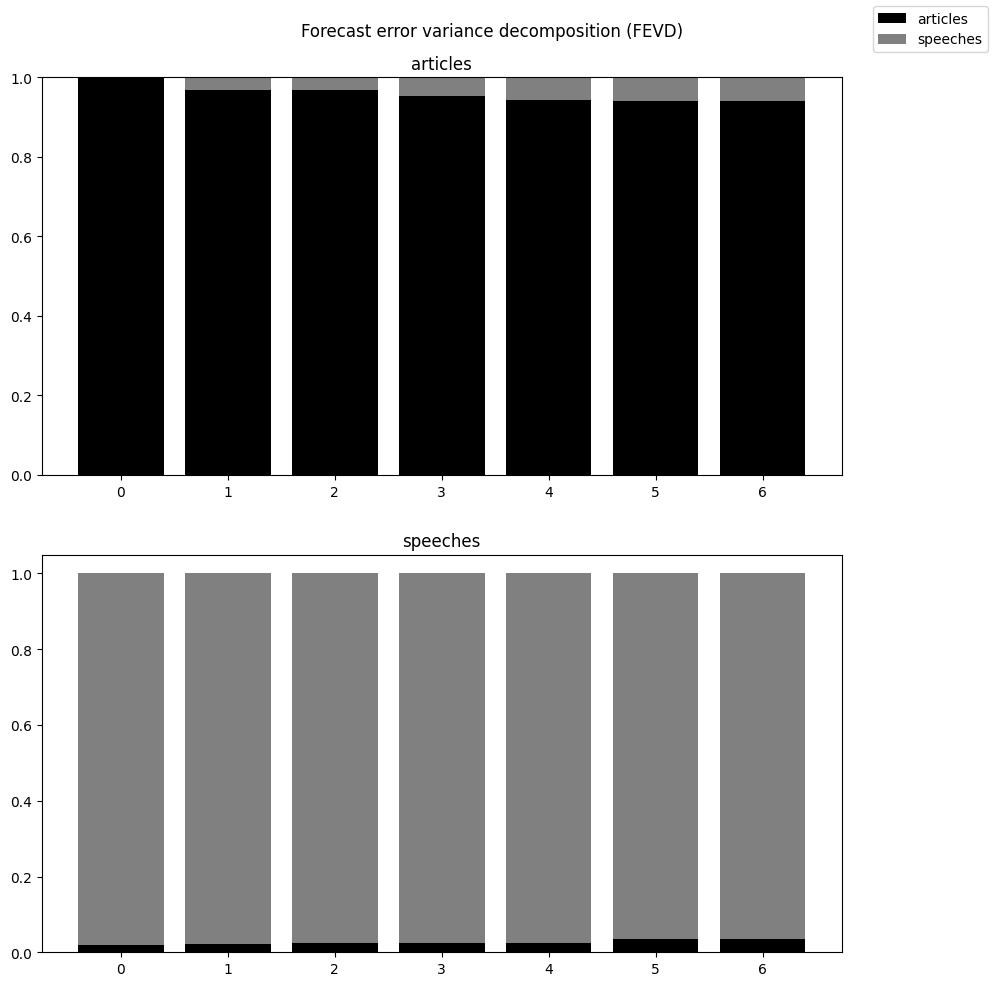

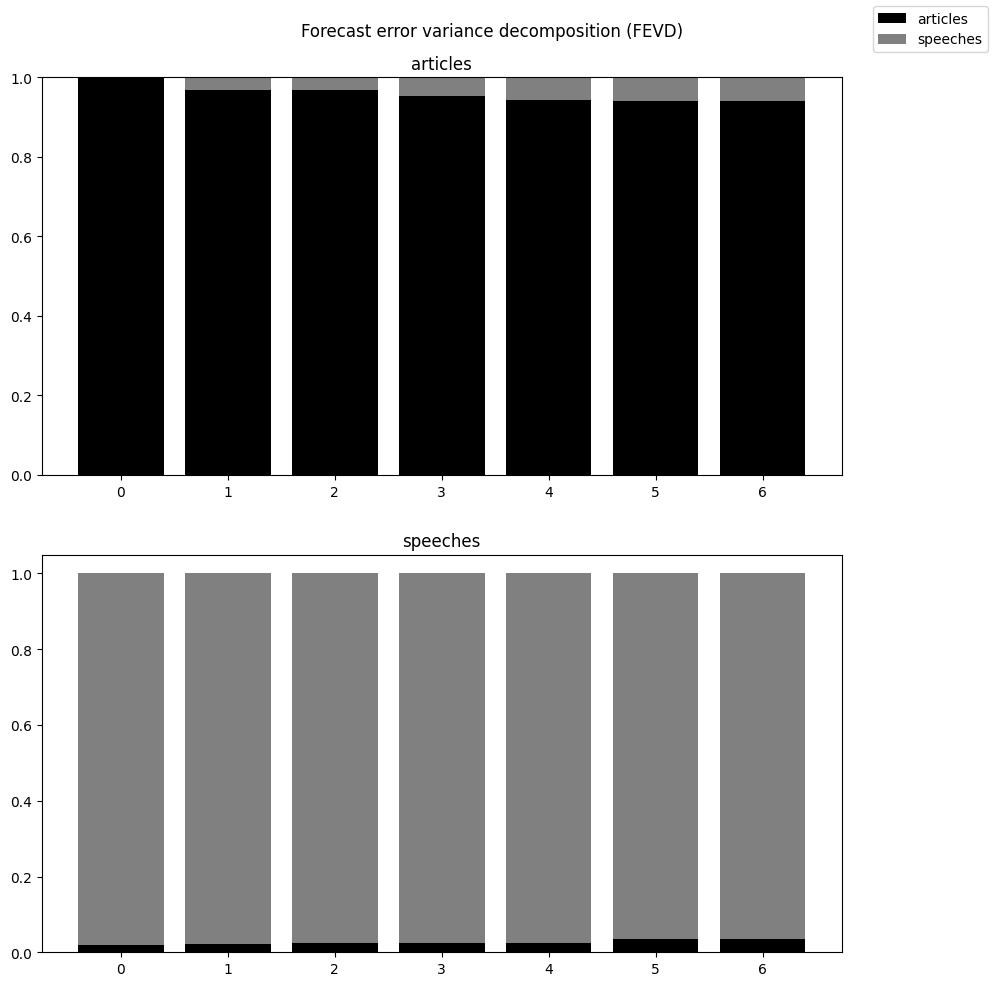

In [22]:
fevd = model_fit.fevd(7)
fevd.summary()

model_fit.fevd(7).plot()

In [23]:
print("Do debates cause news?")
granger_news = grangercausalitytests(merged_df_diff[['articles', 'speeches']], 1)

print("\nDoes news cause debates?")
granger_debates = grangercausalitytests(merged_df_diff[['speeches', 'articles']], 3)

Do debates cause news?

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.8682  , p=0.0031  , df_denom=459, df_num=1
ssr based chi2 test:   chi2=8.9261  , p=0.0028  , df=1
likelihood ratio test: chi2=8.8410  , p=0.0029  , df=1
parameter F test:         F=8.8682  , p=0.0031  , df_denom=459, df_num=1

Does news cause debates?

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.1065  , p=0.0138  , df_denom=459, df_num=1
ssr based chi2 test:   chi2=6.1464  , p=0.0132  , df=1
likelihood ratio test: chi2=6.1058  , p=0.0135  , df=1
parameter F test:         F=6.1065  , p=0.0138  , df_denom=459, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.2664  , p=0.0008  , df_denom=456, df_num=2
ssr based chi2 test:   chi2=14.6922 , p=0.0006  , df=2
likelihood ratio test: chi2=14.4630 , p=0.0007  , df=2
parameter F test:         F=7.2664  , p=0.0008  , df_denom=456, df_num=2

Granger Causality
number of lags (no zero) 3